In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime
import joblib
import ta
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [4]:
#Download Data
start_date = "2015-01-01"
end_date = str(datetime.now().date())

df = yf.download('AAPL', start=start_date, end=end_date)
df.reset_index(inplace=True)

[*********************100%***********************]  1 of 1 completed


In [13]:
train_dates = pd.to_datetime(df["Date"])

In [6]:
cols = list(df)[1:6]
df_for_training = df[cols].astype(float)

In [7]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [24]:
trainX = []
trainY = []

n_future = 1 
n_past = 21

In [25]:
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (2524, 21, 5).
trainY shape == (2524, 1).


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 21, 64)            17920     
                                                                 
 lstm_5 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 30369 (118.63 KB)
Trainable params: 30369 (118.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
142/142 [==============================] - 2s 8ms/step - loss: 0.0699 - val_loss: 0.0793
Epoch 2/10
142/142 [============================

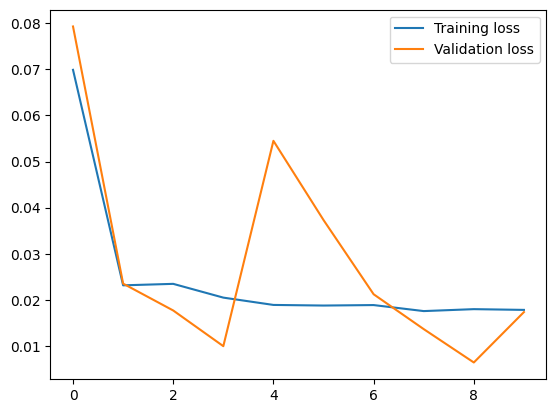

In [26]:
model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [27]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 21
n_days_for_prediction=90  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


[Timestamp('2025-01-15 00:00:00'), Timestamp('2025-01-16 00:00:00'), Timestamp('2025-01-17 00:00:00'), Timestamp('2025-01-21 00:00:00'), Timestamp('2025-01-22 00:00:00'), Timestamp('2025-01-23 00:00:00'), Timestamp('2025-01-24 00:00:00'), Timestamp('2025-01-27 00:00:00'), Timestamp('2025-01-28 00:00:00'), Timestamp('2025-01-29 00:00:00'), Timestamp('2025-01-30 00:00:00'), Timestamp('2025-01-31 00:00:00'), Timestamp('2025-02-03 00:00:00'), Timestamp('2025-02-04 00:00:00'), Timestamp('2025-02-05 00:00:00'), Timestamp('2025-02-06 00:00:00'), Timestamp('2025-02-07 00:00:00'), Timestamp('2025-02-10 00:00:00'), Timestamp('2025-02-11 00:00:00'), Timestamp('2025-02-12 00:00:00'), Timestamp('2025-02-13 00:00:00'), Timestamp('2025-02-14 00:00:00'), Timestamp('2025-02-18 00:00:00'), Timestamp('2025-02-19 00:00:00'), Timestamp('2025-02-20 00:00:00'), Timestamp('2025-02-21 00:00:00'), Timestamp('2025-02-24 00:00:00'), Timestamp('2025-02-25 00:00:00'), Timestamp('2025-02-26 00:00:00'), Timestamp('20

<Axes: xlabel='Date', ylabel='Open'>

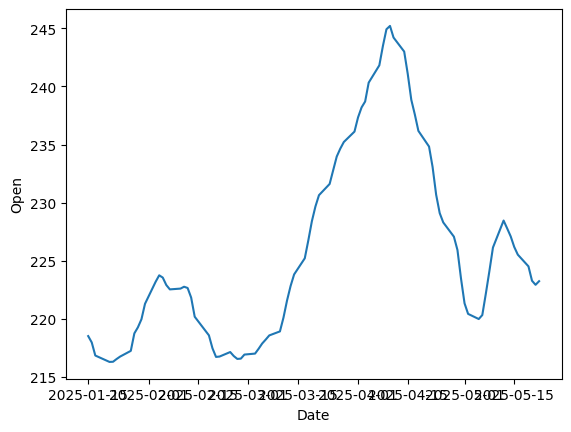

In [28]:
original = df[['Date', 'Open']].copy()

# Ensure 'Date' is in datetime format
original['Date'] = pd.to_datetime(original['Date'])

# Ensure 'Open' is a 1D Series (convert to avoid shape issues)
original['Open'] = original['Open'].squeeze()

# Plot using seaborn
sns.lineplot(data=df_forecast, x='Date', y='Open')

[*********************100%***********************]  1 of 1 completed

2530   2025-01-24
2531   2025-01-27
2532   2025-01-28
2533   2025-01-29
2534   2025-01-30
2535   2025-01-31
2536   2025-02-03
2537   2025-02-04
2538   2025-02-05
2539   2025-02-06
2540   2025-02-07
2541   2025-02-10
2542   2025-02-11
2543   2025-02-12
2544   2025-02-13
Name: Date, dtype: datetime64[ns]
[('Close', 'GE'), ('High', 'GE'), ('Low', 'GE'), ('Open', 'GE'), ('Volume', 'GE')]
trainX shape == (2531, 14, 5).
trainY shape == (2531, 1).
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 14, 64)            17920     
                                                                 
 lstm_7 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dens

Epoch 1/5
143/143 [==============================] - 2s 7ms/step - loss: 0.0870 - val_loss: 0.3486
Epoch 2/5
143/143 [==============================] - 1s 5ms/step - loss: 0.0252 - val_loss: 0.0339
Epoch 3/5
143/143 [==============================] - 1s 5ms/step - loss: 0.0235 - val_loss: 0.0364
Epoch 4/5
143/143 [==============================] - 1s 5ms/step - loss: 0.0220 - val_loss: 0.0231
Epoch 5/5
143/143 [==============================] - 1s 5ms/step - loss: 0.0230 - val_loss: 0.0540
[Timestamp('2025-01-23 00:00:00'), Timestamp('2025-01-24 00:00:00'), Timestamp('2025-01-27 00:00:00'), Timestamp('2025-01-28 00:00:00'), Timestamp('2025-01-29 00:00:00'), Timestamp('2025-01-30 00:00:00'), Timestamp('2025-01-31 00:00:00'), Timestamp('2025-02-03 00:00:00'), Timestamp('2025-02-04 00:00:00'), Timestamp('2025-02-05 00:00:00'), Timestamp('2025-02-06 00:00:00'), Timestamp('2025-02-07 00:00:00'), Timestamp('2025-02-10 00:00:00'), Timestamp('2025-02-11 00:00:00'), Timestamp('2025-02-12 00:00:

C:\Users\Soham Mandavkar\AppData\Local\Temp\ipykernel_4372\1380206547.py:134: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


TypeError: lineplot() takes from 0 to 1 positional arguments but 2 were given

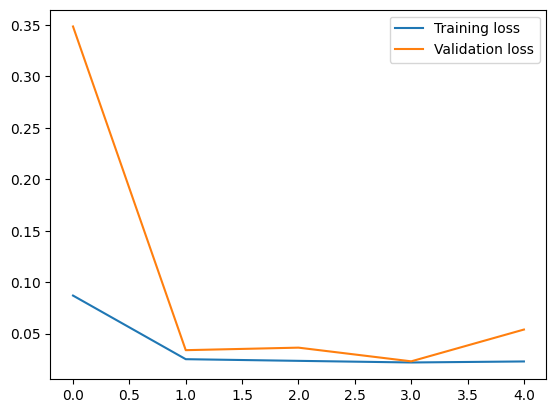

In [29]:
# https://youtu.be/tepxdcepTbY
"""
@author: Sreenivas Bhattiprolu

Code tested on Tensorflow: 2.2.0
    Keras: 2.4.3

dataset: https://finance.yahoo.com/quote/GE/history/
Also try S&P: https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC
"""

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
#from datetime import datetime

start_date = "2015-01-01"
end_date = str(datetime.now().date())
#Read the csv file
df = yf.download('GE', start=start_date, end=end_date)
df.reset_index(inplace=True)#7 columns, including the Date. 

#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

#Variables for training
cols = list(df)[1:6]
#Date and volume columns are not used in training. 
print(cols) #['Open', 'High', 'Low', 'Close', 'Adj Close']

#New dataframe with only training data - 5 columns
df_for_training = df[cols].astype(float)

# df_for_plot=df_for_training.tail(5000)
# df_for_plot.plot.line()

#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)


#As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
#In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 14  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

#In my case, trainX has a shape (12809, 14, 5). 
#12809 because we are looking back 14 days (12823 - 14 = 12809). 
#Remember that we cannot look back 14 days until we get to the 15th day. 
#Also, trainY has a shape (12809, 1). Our model only predicts a single value, but 
#it needs multiple variables (5 in my example) to make this prediction. 
#This is why we can only predict a single day after our training, the day after where our data ends.
#To predict more days in future, we need all the 5 variables which we do not have. 
#We need to predict all variables if we want to do that. 

# define the Autoencoder model

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam', loss='mse')
model.summary()


# fit the model
history = model.fit(trainX, trainY, epochs=5, batch_size=16, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

#Predicting...
#Libraries that will help us extract only business days in the US.
#Otherwise our dates would be wrong when we look back (or forward).  
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
us_bd = CustomBusinessDay(calendar=USFederalHolidayCalendar())
#Remember that we can only predict one day in future as our model needs 5 variables
#as inputs for prediction. We only have all 5 variables until the last day in our dataset.
n_past = 16
n_days_for_prediction=15  #let us predict past 15 days

predict_period_dates = pd.date_range(list(train_dates)[-n_past], periods=n_days_for_prediction, freq=us_bd).tolist()
print(predict_period_dates)

#Make prediction
prediction = model.predict(trainX[-n_days_for_prediction:]) #shape = (n, 1) where n is the n_days_for_prediction

#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(prediction_copies)[:,0]


# Convert timestamp to date
forecast_dates = []
for time_i in predict_period_dates:
    forecast_dates.append(time_i.date())
    
df_forecast = pd.DataFrame({'Date':np.array(forecast_dates), 'Open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])


original = df[['Date', 'Open']]
original['Date']=pd.to_datetime(original['Date'])
original = original.loc[original['Date'] >= '2020-5-1']

sns.lineplot(original['Date'], original['Open'])
sns.lineplot(df_forecast['Date'], df_forecast['Open'])